# Import Required Libraries

In [1]:
import sys

sys.path.insert(0, "../../src")
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "Antisparse_Copula"

# Source Generation and Mixing Scenario

In [2]:
rho = 0.1
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources

SNR = 30  # dB

S = generate_correlated_copula_sources(
    rho=rho,
    df=4,
    n_sources=NumberofSources,
    size_sources=N,
    decreasing_correlation=False,
)

S = 2 * S - 1
A = np.random.standard_normal(size=(NumberofMixtures, NumberofSources))
X = A @ S

X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.003039135904885


# Visualize Generated Sources and Mixtures

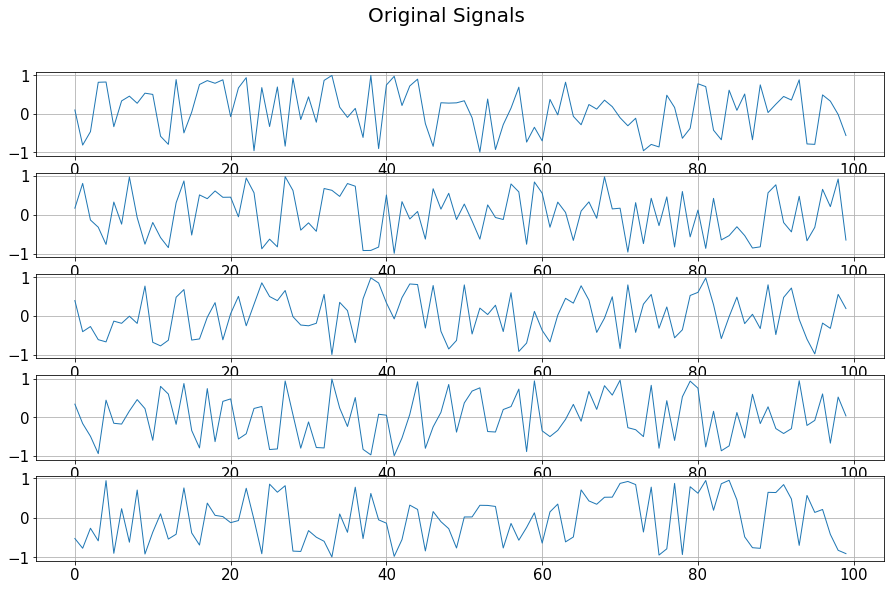

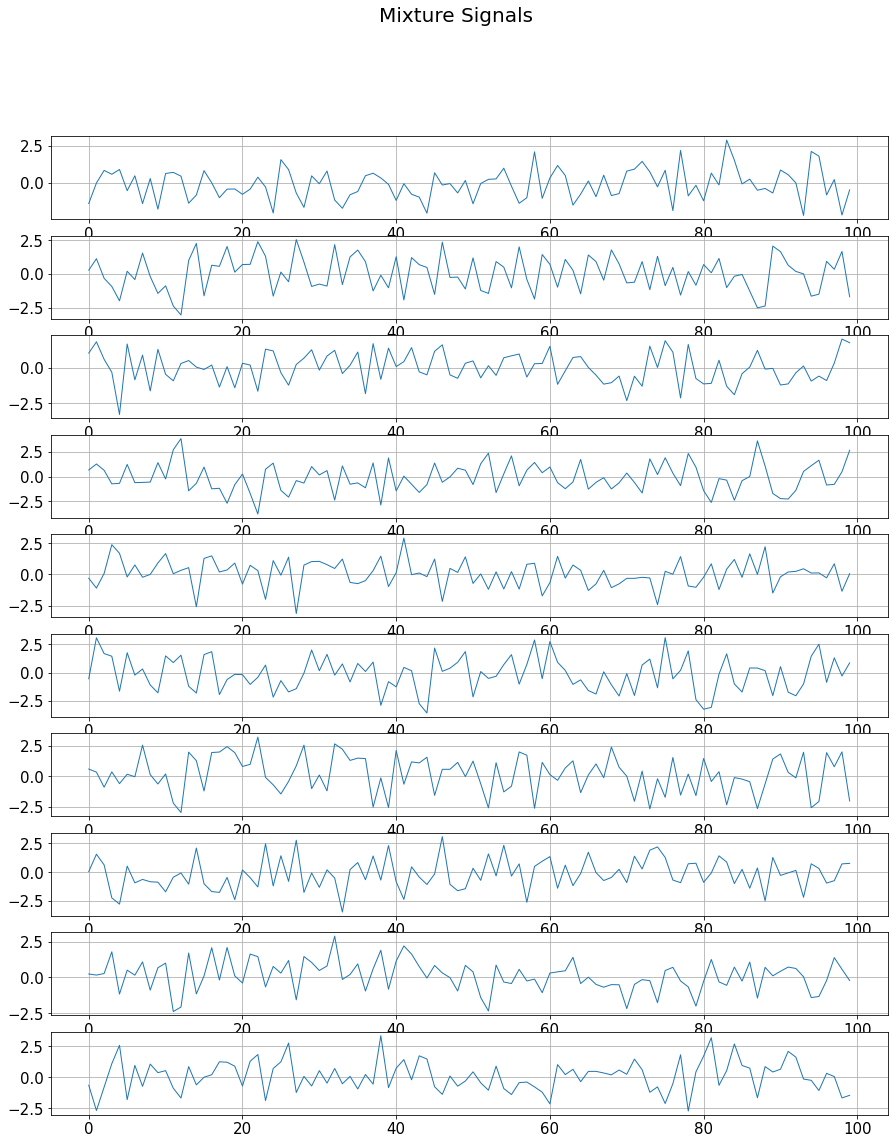

In [3]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
gamma_start = 0.1
gamma_stop = 1e-3

gammaM_H_start = np.array([gamma_start, gamma_start])
gammaM_H_stop = np.array([gamma_stop, gamma_stop])
gammaW_HX_start = np.array([gamma_start, gamma_start])
gammaW_HX_stop = np.array([gamma_stop, gamma_stop])

gammaM_Y_start = np.array([gamma_start, gamma_start])
gammaM_Y_stop = np.array([gamma_stop, gamma_stop])
gammaW_YH_start = np.array([gamma_start, gamma_start])
gammaW_YH_stop = np.array([gamma_stop, gamma_stop])

OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS = 3000
LayerGains = [0.5, 0.5]
LayerGains = [1, 1]
LayerMinimumGains = [0.2, 0.2]
LayerMaximumGains = [1e6, 5]
WScalings = [0.005, 0.005]
GamScalings = [2, 1]
GamScalings = [1, 1]
zeta = 5 * 1e-3
beta = 0.5
muD = np.array([0.01, 0.01])

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
synaptic_lr_rule = "divide_by_log_index"
# OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
neural_loop_lr_rule = "divide_by_slow_loop_index"

synaptic_lr_decay_divider = 50000
neural_lr_decay_multiplier = 0.01

hidden_layer_gain = 10


# W_HX = W_HX + (W_HX!=0)*np.random.uniform(-0.1,0.1, size = (W_HX.shape[0], W_HX.shape[1]))
# W_YH = W_YH + (W_YH!=0)*np.random.uniform(-0.1,0.1, size = (W_YH.shape[0], W_YH.shape[1]))
# D1 = (np.random.uniform(3.99,4.01, size = (h_dim,1)))/2
# D2 = (np.random.uniform(0.99,1.01, size = (s_dim,1)))
# # W_HX = np.random.normal(0, 1.0 / np.sqrt(x_dim), size=(h_dim, x_dim))
# # W_YH = np.random.normal(0, 1.0 / np.sqrt(h_dim), size=(s_dim, h_dim))

# # W_HX = np.random.uniform(-1.0 / np.sqrt(x_dim), 1.0 / np.sqrt(x_dim), size=(h_dim, x_dim))
# # W_YH = np.random.uniform(-1.0 / np.sqrt(h_dim), 1.0 / np.sqrt(h_dim), size=(s_dim, h_dim))

# M_H = np.random.uniform(-1.0 / np.sqrt(h_dim), 1.0 / np.sqrt(h_dim), size=(h_dim, h_dim))
# M_Y = np.random.uniform(-1.0 / np.sqrt(s_dim), 1.0 / np.sqrt(s_dim), size=(s_dim, s_dim))

# zeta = 1 * 1e-5
# beta = 0.5
# muD = np.array([1, 0.1])

# Run WSM Algorithm on Mixture Signals

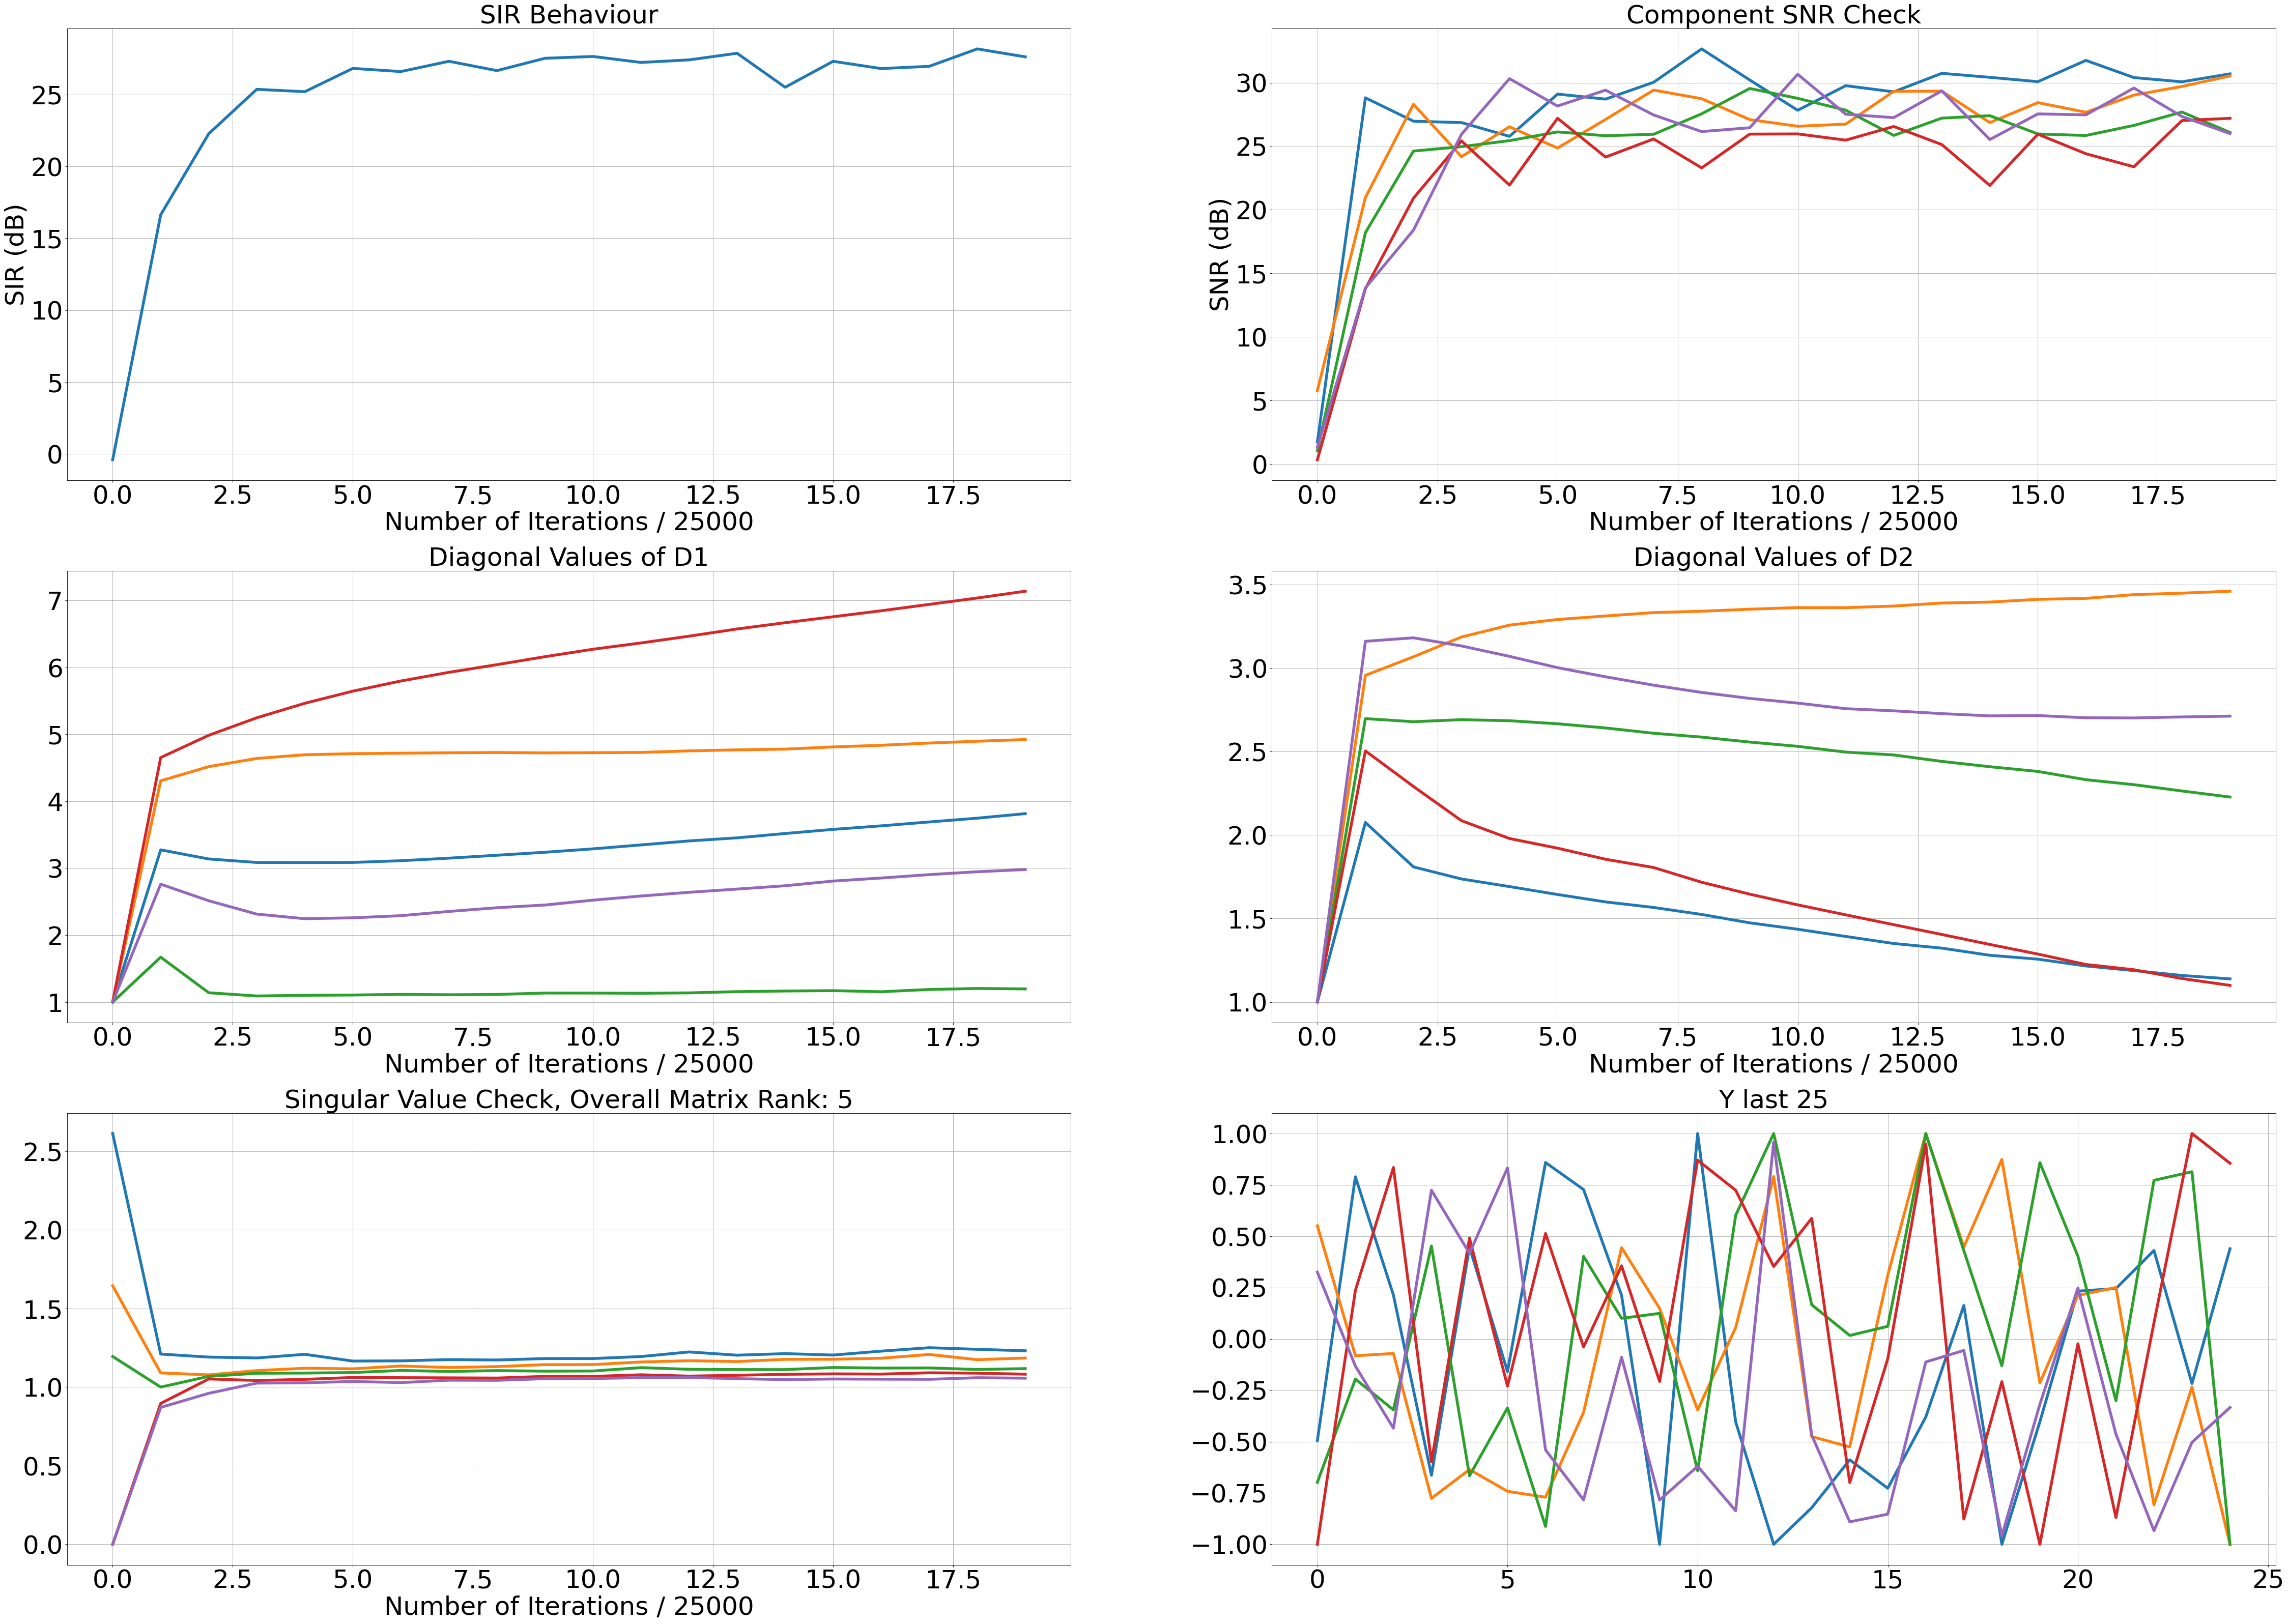

100%|██████████| 500000/500000 [06:16<00:00, 1327.99it/s]


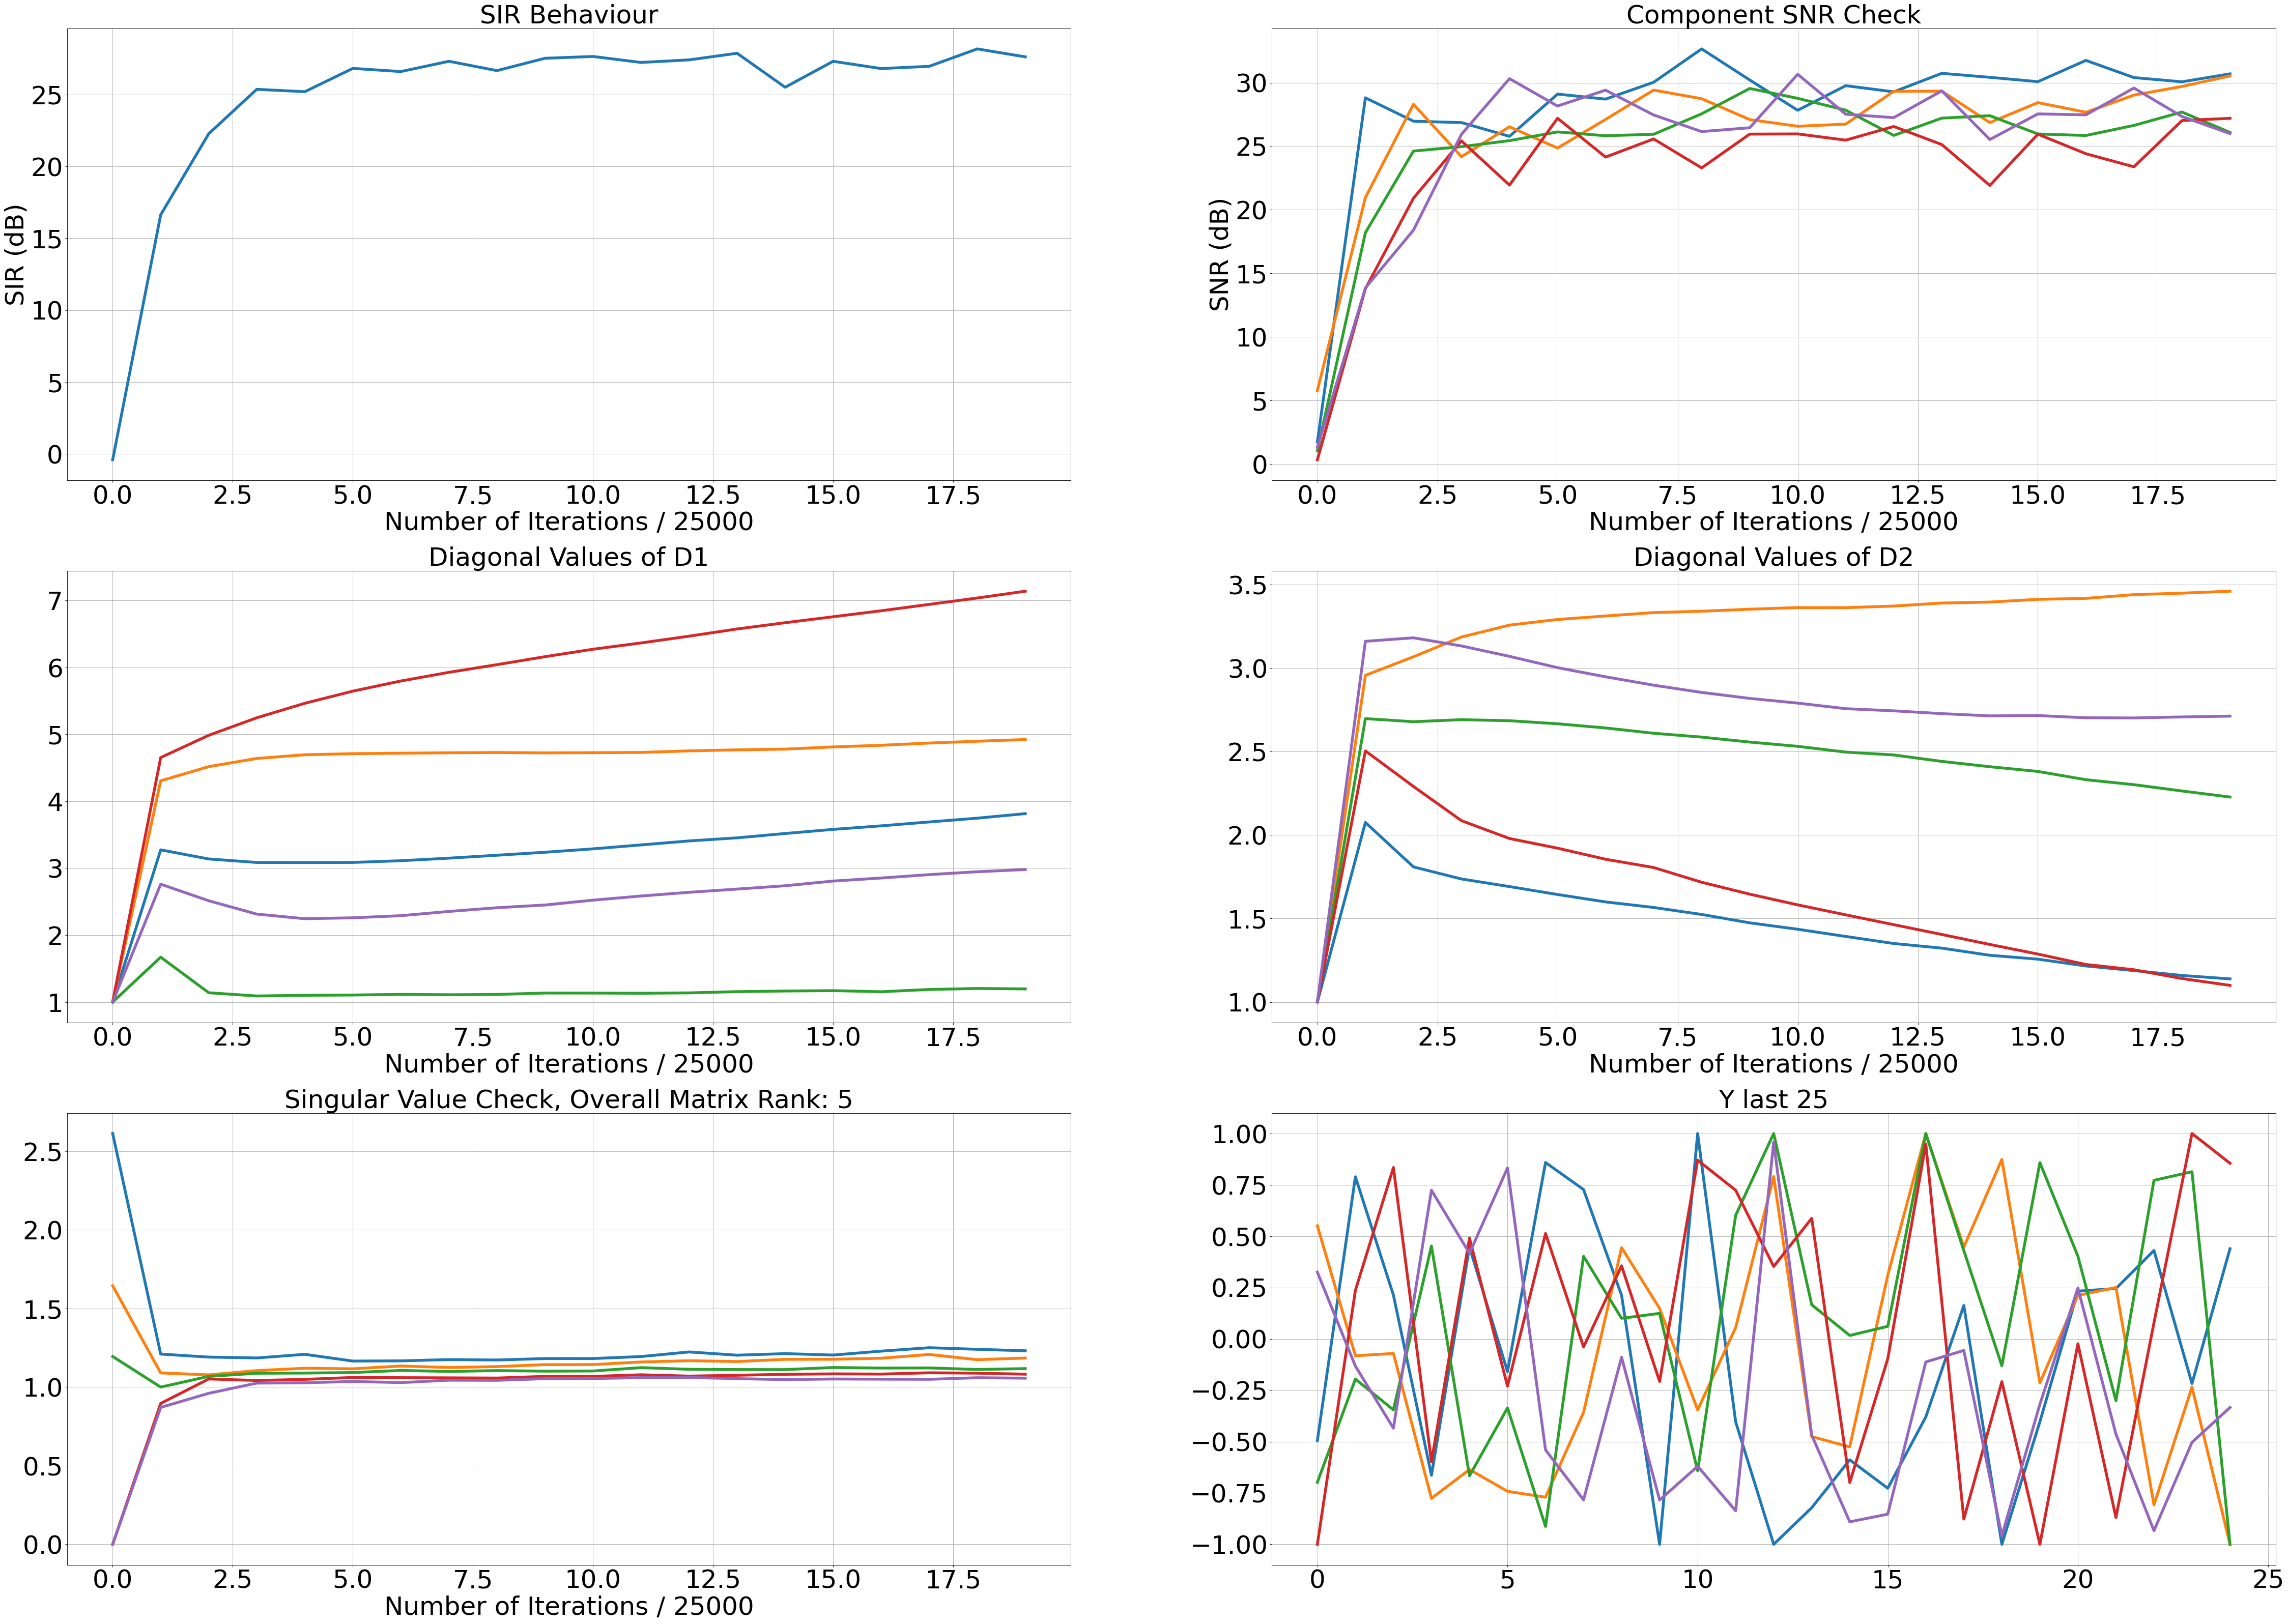

In [5]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSSv2(
    s_dim=s_dim,
    x_dim=x_dim,
    h_dim=h_dim,
    gammaM_H_start=gammaM_H_start,
    gammaM_H_stop=gammaM_H_stop,
    gammaW_HX_start=gammaW_HX_start,
    gammaW_HX_stop=gammaW_HX_stop,
    gammaM_Y_start=gammaM_Y_start,
    gammaM_Y_stop=gammaM_Y_stop,
    gammaW_YH_start=gammaW_YH_start,
    gammaW_YH_stop=gammaW_YH_stop,
    beta=beta,
    zeta=zeta,
    muD=muD,
    WScalings=WScalings,
    GamScalings=GamScalings,
    W_HX=W_HX,
    W_YH=W_YH,
#     M_H = M_H,
#     M_Y = M_Y,
#     D1 = D1, 
#     D2 = D2,
    DScalings=LayerGains,
    LayerMinimumGains=LayerMinimumGains,
    LayerMaximumGains=LayerMaximumGains,
    neural_OUTPUT_COMP_TOL=OUTPUT_COMP_TOL,
    set_ground_truth=True,
    S=S,
    A=A,
)


modelWSM.fit_batch_antisparse(
    X,
    n_epochs=1,
    neural_dynamic_iterations=750,
    neural_lr_start=0.5,
    neural_lr_stop=0.001,
    synaptic_lr_rule=synaptic_lr_rule,
    neural_loop_lr_rule=neural_loop_lr_rule,
    synaptic_lr_decay_divider=synaptic_lr_decay_divider,
    neural_lr_decay_multiplier=neural_lr_decay_multiplier,
    hidden_layer_gain=hidden_layer_gain,
    clip_gain_gradients=True,
    gain_grads_clipping_multiplier = 0.1,
    debug_iteration_point=debug_iteration_point,
    plot_in_jupyter=True,
)

# Visualize SNR Convergence of Each Source Component

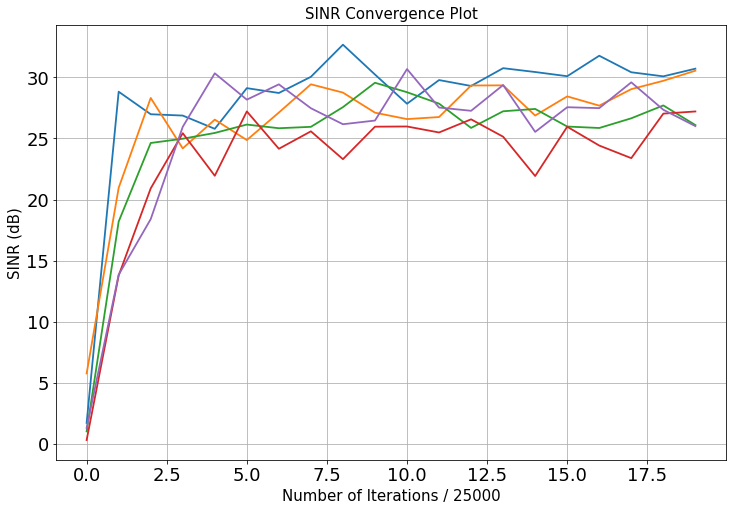

In [6]:
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
plot_convergence_plot(
    modelWSM.SNR_list,
    xlabel="Number of Iterations / {}".format(debug_iteration_point),
    ylabel="SINR (dB)",
    title="SINR Convergence Plot",
    colorcode=None,
    linewidth=1.8,
)

# Calculate Resulting Component SNRs and Overall SINR

In [7]:
Wf = modelWSM.compute_overall_mapping(return_mapping=True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10 * np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [30.28356342 27.72735662 26.53785891 25.39671771 23.18036579]

Overall SINR : 25.997670650606622


# Vizualize Extracted Signals Compared to Original Sources

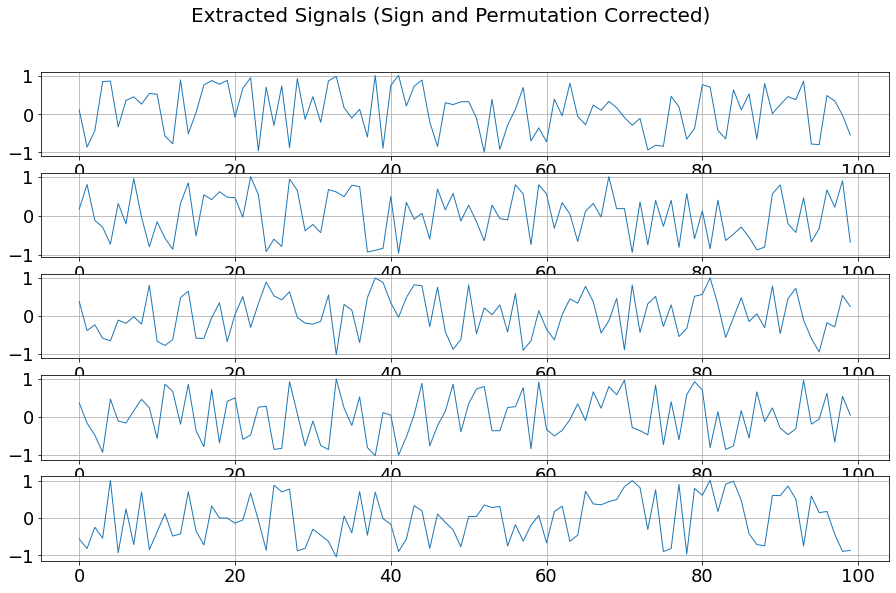

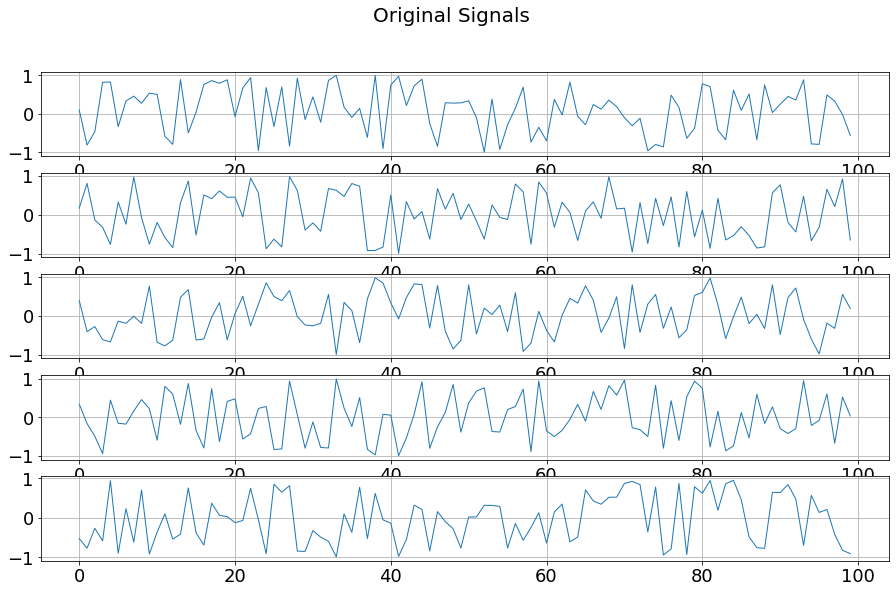

In [8]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)